# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import json
from pandas import json_normalize
import os
from sklearn.preprocessing import StandardScaler

# Reaching the target website and loading the data

In [2]:

url = f"https://understat.com/league/EPL/2023"

res = requests.get(url)
soup = BeautifulSoup(res.content, 'lxml')
scripts = soup.find_all('script')

# df_game_hist Data

strings = scripts[2].string

ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

data = json.loads(json_data)

rows = []
for team_id, team_info in data.items():
    for record in team_info['history']:
        record['team_id'] = team_id
        record['team_title'] = team_info['title']
        record['ppda_att'] = record['ppda']['att']
        record['ppda_def'] = record['ppda']['def']
        record['ppda_allowed_att'] = record['ppda_allowed']['att']
        record['ppda_allowed_def'] = record['ppda_allowed']['def']
        del record['ppda'], record['ppda_allowed']
        record['oppda'] = (record['ppda_allowed_att'] / record['ppda_allowed_def'])
        record['ppda'] = (record['ppda_att'] / record['ppda_def'])
        # del record['ppda_allowed_def'], record['ppda_def'], record['ppda_allowed_att'], record['ppda_att']
        rows.append(record)

df_game_hist = pd.DataFrame(rows)

# df_games Data

strings = scripts[1].string

ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

data = json.loads(json_data)
df_games = json_normalize(data)
df_games.dropna(inplace=True)

# df_players Data

strings = scripts[3].string

ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

data = json.loads(json_data)
df_players = json_normalize(data)

# Using a "for" loop to reach data for each match individually (this will take time)
# df_shots & df_appear Data

df_matches = df_games.dropna()
df_shots = pd.DataFrame()
df_appear = pd.DataFrame()
base_url = 'https://understat.com/match/'

for match in df_matches["id"]:

    # Reaching the website
    url = base_url+match

    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'lxml')
    scripts = soup.find_all('script')

    # df_shots Data
    strings = scripts[1].string

    ind_start = strings.index("('")+2 
    ind_end = strings.index("')") 
    json_data = strings[ind_start:ind_end] 
    json_data = json_data.encode('utf8').decode('unicode_escape')

    data = json.loads(json_data)

    data_h = data["h"]
    data_a = data["a"]

    data_h = json_normalize(data_h)
    data_a = json_normalize(data_a)

    df_temp = pd.concat([data_a, data_h])
    df_temp["match_id"] = match
    df_shots = pd.concat([df_shots, df_temp])

    # df_appear Data
    strings= scripts[2].string

    ind_start = strings.index("('")+2 
    ind_end = strings.index("')") 
    json_data = strings[ind_start:ind_end] 
    json_data = json_data.encode('utf8').decode('unicode_escape')

    data_events = json.loads(json_data)

    data_events_h = data_events["h"].values()
    data_events_a = data_events["a"].values()

    data_events_h = pd.DataFrame(data_events_h)
    data_events_a = pd.DataFrame(data_events_a)

    df_temp_events = pd.concat([data_events_a, data_events_h])
    df_temp_events["match_id"] = match
    df_appear = pd.concat([df_appear, df_temp_events])

# exporting as .csv

In [72]:
df_appear.to_csv('df_appear.csv', index=False)
df_shots.to_csv('df_shots.csv', index=False)
df_players.to_csv('df_players.csv', index=False)
df_games.to_csv('df_games.csv', index=False)
df_game_hist.to_csv('df_game_hist.csv', index=False)

#  importing from .csv

In [4]:
df_appear = pd.read_csv('df_appear.csv')
df_shots = pd.read_csv('df_shots.csv')
df_players = pd.read_csv('df_players.csv')
df_games = pd.read_csv('df_games.csv')
df_game_hist = pd.read_csv('df_game_hist.csv')


In [71]:
df_shots.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,531929,3,Goal,0.937,0.506,0.505846,Erling Haaland,a,8260,FromCorner,2023,LeftFoot,22275,Burnley,Manchester City,0,3,2023-08-11 19:00:00,Rodri,HeadPass
1,531930,5,MissedShots,0.719,0.389,0.018894,Kevin De Bruyne,a,447,OpenPlay,2023,RightFoot,22275,Burnley,Manchester City,0,3,2023-08-11 19:00:00,Phil Foden,Pass
2,531931,10,MissedShots,0.952,0.421,0.130247,Erling Haaland,a,8260,OpenPlay,2023,RightFoot,22275,Burnley,Manchester City,0,3,2023-08-11 19:00:00,Kevin De Bruyne,Cross
3,531935,35,Goal,0.891,0.385,0.113214,Erling Haaland,a,8260,OpenPlay,2023,LeftFoot,22275,Burnley,Manchester City,0,3,2023-08-11 19:00:00,Julián Álvarez,Pass
4,531937,45,SavedShot,0.898,0.482,0.168700,Phil Foden,a,6055,OpenPlay,2023,LeftFoot,22275,Burnley,Manchester City,0,3,2023-08-11 19:00:00,Mateo Kovacic,TakeOn


# Data Manipulation

In [5]:
def convert_to_num(df):
    for column in df.columns:
        try:
            df[column] = df[column].astype(float)
            if (df[column].astype(int) == df[column]).all():
                df[column] = df[column].astype(int)
        except ValueError:
            continue
    return df

In [6]:
df = [df_shots, df_games, df_game_hist, df_appear, df_players]
for i in df:
    i = convert_to_num(i)

# df_team_shots creator function

In [7]:
def team_specific_shots(team):
    df_team_shots = pd.DataFrame()
    df_team_shots = df_shots[((df_shots["h_team"] == team) & (df_shots["h_a"] == "h")) | ((df_shots["a_team"] == team) & (df_shots["h_a"] == "a"))]
    return df_team_shots

# Numeric Variable Distributions (df_game_hist)

In [8]:
df_game_hist.columns

Index(['h_a', 'xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored',
       'missed', 'xpts', 'result', 'date', 'wins', 'draws', 'loses', 'pts',
       'npxGD', 'team_id', 'team_title', 'ppda_att', 'ppda_def',
       'ppda_allowed_att', 'ppda_allowed_def', 'oppda', 'ppda'],
      dtype='object')

In [9]:
df = df_game_hist[["ppda", "xG", "deep", "xpts", 'oppda']][df_game_hist["team_title"]=="Manchester City"]

In [10]:
for i in df.columns:
    df[i] = (df[i] - df[i].min()) / (df[i].max() - df[i].min())

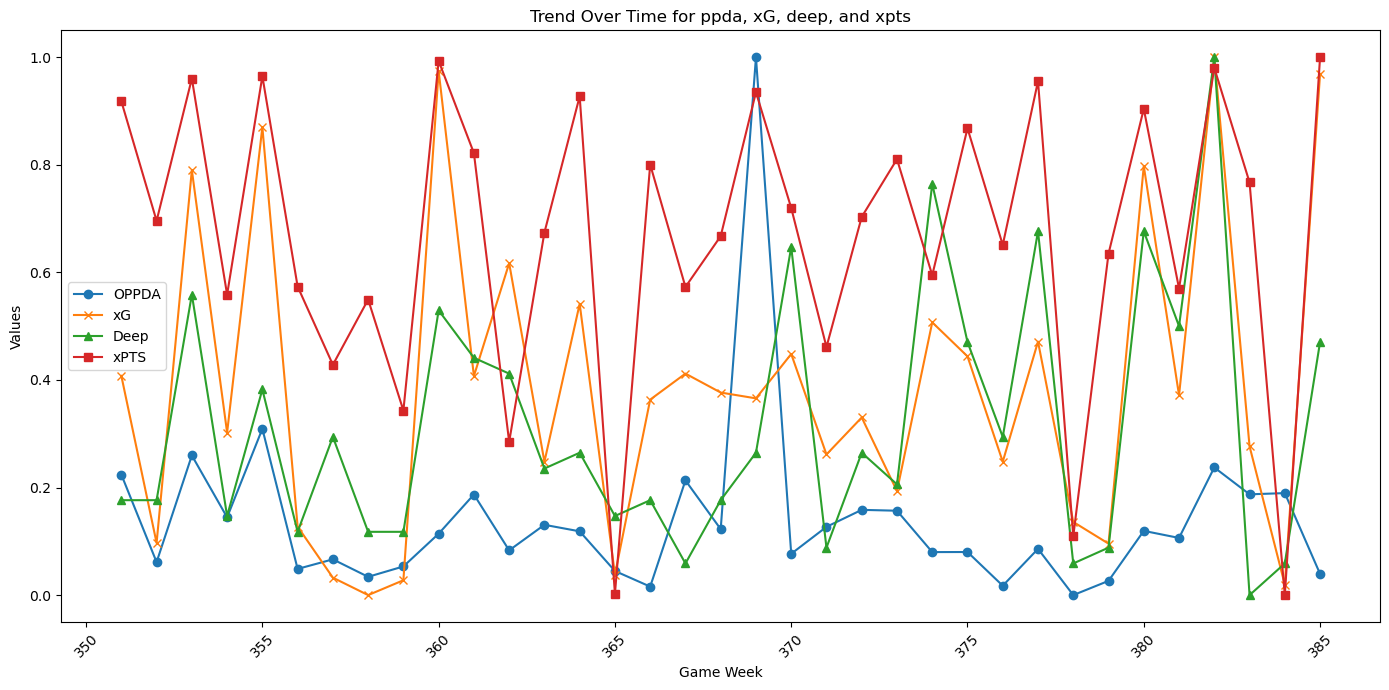

In [11]:
df.sort_index(inplace=True)

# Plot the 'ppda', 'xG', 'deep', and 'xpts' columns
plt.figure(figsize=(14, 7))  # Set the figure size for better readability

plt.plot(df['oppda'], label='OPPDA', marker='o')
plt.plot(df['xG'], label='xG', marker='x')
plt.plot(df['deep'], label='Deep', marker='^')
plt.plot(df['xpts'], label='xPTS', marker='s')

# Add titles and labels
plt.title('Trend Over Time for ppda, xG, deep, and xpts')
plt.xlabel('Game Week')
plt.ylabel('Values')

# Show the legend
plt.legend()

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [12]:
print(
np.mean(df_game_hist[["xGA"]][(df_game_hist["team_title"] == "Everton")
& ((df_game_hist['ppda_allowed_def'] - df_game_hist['ppda_def']) < -5)])
,
np.mean(df_game_hist[["xGA"]][(df_game_hist["team_title"] == "Everton")
& ((df_game_hist['ppda_allowed_def'] - df_game_hist['ppda_def']) > 5)])
)

xGA    1.631146
dtype: float64 xGA    1.584079
dtype: float64


C:\Users\G\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\G\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Sonuç: ppda_att ile ppda_allowed_att değişkenlerinin farkının xg üzerinde doğrudan etkisi var.

In [13]:
print(
np.mean(df_game_hist[['ppda_allowed_def']][df_game_hist["team_title"] == "Manchester City"]),
np.mean(df_game_hist[['ppda_def']][df_game_hist["team_title"] == "Manchester City"]),
"\n",
np.mean(df_game_hist[['ppda_allowed_att']][df_game_hist["team_title"] == "Manchester City"]),
np.mean(df_game_hist[['ppda_att']][df_game_hist["team_title"] == "Manchester City"])
)

ppda_allowed_def    17.714286
dtype: float64 ppda_def    19.2
dtype: float64 
 ppda_allowed_att    349.6
dtype: float64 ppda_att    213.342857
dtype: float64


C:\Users\G\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\G\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\G\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\G\anaconda3\lib\site-packages\nump

# xG Distribution on 5 minute-range Intervals by Teams (df_shots)

In [14]:
df_team_shots = team_specific_shots("Luton")

In [15]:
def categorize_period(df):
    period = (df['minute'] // 5) * 5
    return f"{period}-{period + 4}"
df_team_shots['period'] = df_team_shots.apply(categorize_period, axis=1)

C:\Users\G\AppData\Local\Temp\ipykernel_14040\3543908787.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team_shots['period'] = df_team_shots.apply(categorize_period, axis=1)


In [16]:
grouped_xG = df_team_shots.groupby('period')['xG'].agg(["mean", "sum"])
custom_order = ['0-4', '5-9', '10-14', '15-19',
                '20-24','25-29', '30-34', '35-39',
                '40-44','45-49', '50-54', '55-59',
                '60-64','65-69', '70-74', '75-79',
                '80-84','85-89', '90-94', '95-99']
grouped_xG = grouped_xG.reindex(custom_order)

In [17]:
grouped_xG.head()

,mean,sum
period,,
0-4,0.147134,2.207009
5-9,0.090546,1.358184
10-14,0.100152,1.802742
15-19,0.079580,0.954965
20-24,0.163577,3.925844


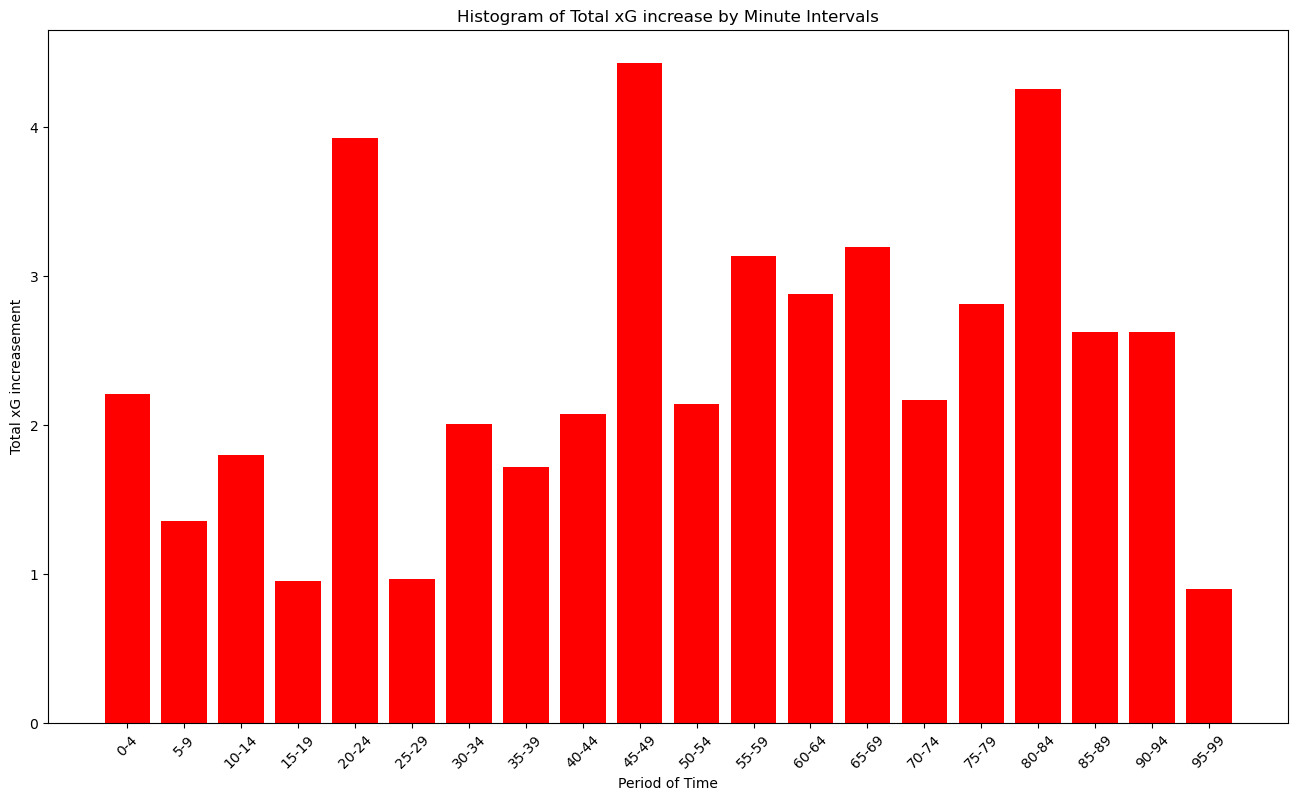

In [18]:
plt.figure(figsize=(16, 9))

plt.bar(grouped_xG.index, grouped_xG["sum"], color='red')

plt.xticks(rotation=45) 
plt.xlabel('Period of Time')
plt.ylabel('Total xG increasement')
plt.title('Histogram of Total xG increase by Minute Intervals')
plt.show()

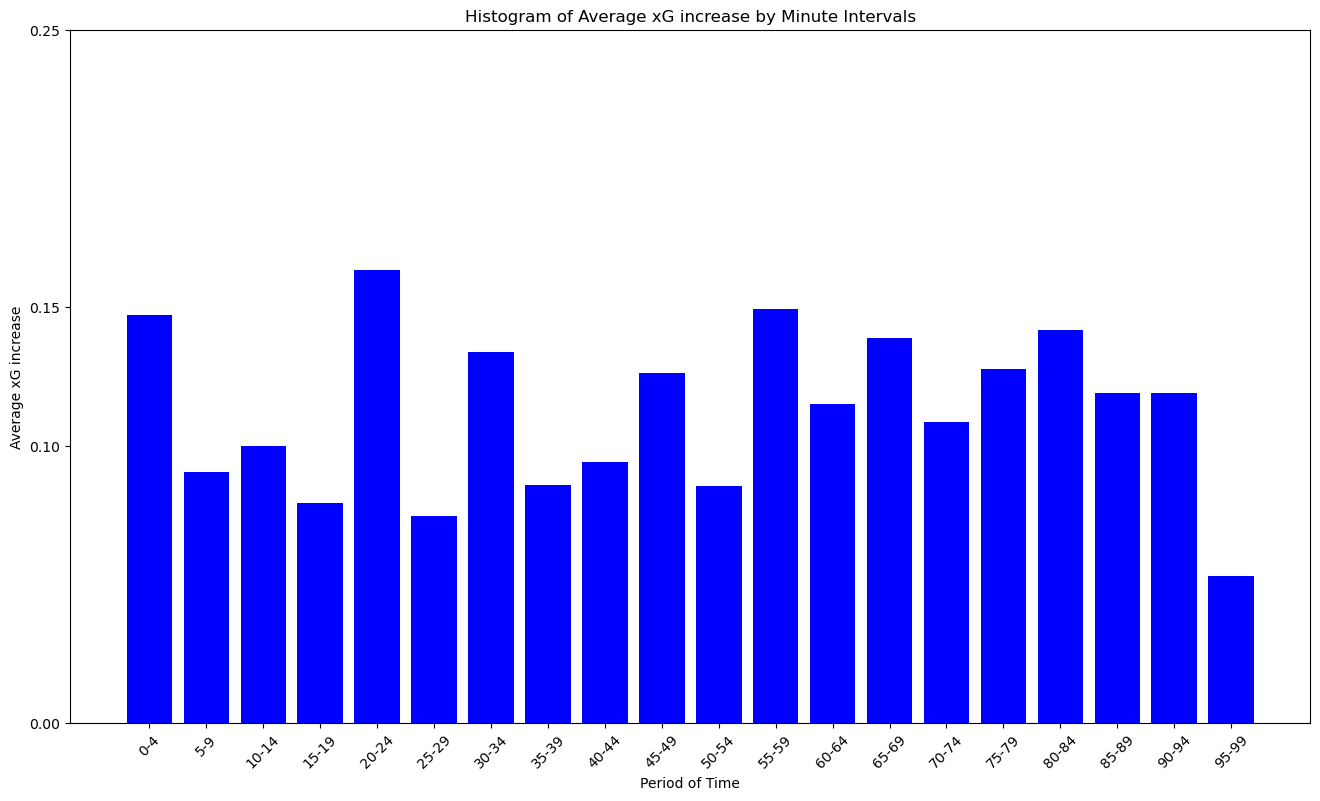

In [19]:
plt.figure(figsize=(16, 9))
plt.bar(grouped_xG.index, grouped_xG["mean"], color='blue')

plt.xticks(rotation=45)
plt.xlabel('Period of Time')
plt.ylabel('Average xG increase')
plt.yticks([0,0.1, 0.15, 0.25])
plt.title('Histogram of Average xG increase by Minute Intervals')
plt.show()

# Correlation Matrix (df_game_hist)

In [20]:
df_game_hist.dropna(inplace=True)
corr_games = df_game_hist[["xG", "deep", "oppda", "scored", "pts", "xpts", "xGA", "deep_allowed", "ppda", "missed"]][df_game_hist["h_a"] == "h"].corr()

Text(0.5, 1.0, 'df_game_hist Korelasyon Matrisi')

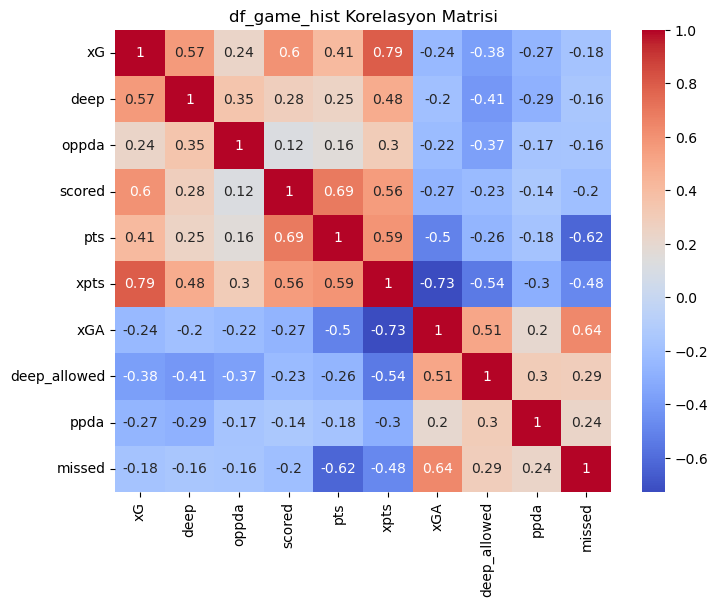

In [21]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_games, annot=True, cmap='coolwarm', cbar=True)
plt.title("df_game_hist Korelasyon Matrisi")

# df_teams Data (generating from df_game_hist)

In [22]:
df_teams = df_game_hist[['team_title', "xG", "npxG", "deep", "oppda", "scored", "pts", "xpts", "xGA", "deep_allowed", "ppda", "missed", "npxGD", "wins", "draws", "loses"]] 
df_teams = df_teams.groupby('team_title')[["xG", "npxG", "deep", "oppda", "scored", "pts", "xpts", "xGA", "deep_allowed", "ppda", "missed", "npxGD", "wins", "draws", "loses"]].agg(["mean", "sum"])

# Comparing teams with high "xpts" accuracy with low ones

In [23]:
df_teams["xpts_dif"] = df_teams["xpts", "sum"] - df_teams["pts", "sum"]
df_teams["xG_dif"] = df_teams["xG", "sum"] - df_teams["scored", "sum"]

dif_mean = np.mean(df_teams["xpts_dif"])
dif_std =np.std(df_teams["xpts_dif"])
                
dif_floor = dif_mean - dif_std
dif_ceil = dif_mean + dif_std
 
df_teams_expected = df_teams[(df_teams["xpts_dif"] <  dif_ceil - 1) & (df_teams["xpts_dif"] >  dif_floor + 1)]
df_teams_unexpected = df_teams[(df_teams["xpts_dif"] >  dif_ceil + 1) | (df_teams["xpts_dif"] <  dif_floor - 1)]

In [24]:
df_teams_expected

xG                 npxG                  deep  \
                             mean        sum      mean        sum       mean   
team_title                                                                     
Arsenal                  2.206937  79.449739  1.995502  71.838089  13.944444   
Bournemouth              1.685585  60.681076  1.622155  58.397576   7.833333   
Brighton                 1.590096  54.063252  1.478161  50.257474   9.676471   
Chelsea                  2.091492  71.110744  1.822845  61.976732  10.000000   
Crystal Palace           1.346384  47.123444  1.259394  44.078778   6.057143   
Everton                  1.618477  58.265161  1.555046  55.981645   6.250000   
Fulham                   1.433447  51.604091  1.391160  50.081754   7.833333   
Liverpool                2.398971  83.963972  2.195105  76.828662  13.114286   
Luton                    1.310127  47.164576  1.225553  44.119906   4.694444   
Manchester City          2.325092  81.378223  2.151111  75.288873  13.742857   
Newcastle United         2.174263  76.099212  1.978534  69.248693   9.085714   
Wolverhampton Wanderers  1.354580  48.764887  1.270006  45.720205   5.833333   

                                  oppda                scored      ...  \
                         sum       mean         sum      mean sum  ...   
team_title                                                         ...   
Arsenal                  502  19.527568  702.992441  2.444444  88  ...   
Bournemouth              282   9.218288  331.858386  1.444444  52  ...   
Brighton                 329  24.096661  819.286487  1.529412  52  ...   
Chelsea                  340  15.662855  532.537084  1.911765  65  ...   
Crystal Palace           212   9.094762  318.316678  1.285714  45  ...   
Everton                  225  10.848137  390.532930  1.055556  38  ...   
Fulham                   282  14.363474  517.085063  1.416667  51  ...   
Liverpool                459  19.525904  683.406639  2.200000  77  ...   
Luton                    169   8.090834  291.270029  1.361111  49  ...   
Manchester City          481  24.065112  842.278933  2.485714  87  ...   
Newcastle United         318  12.238359  428.342557  2.228571  78  ...   
Wolverhampton Wanderers  210  10.986612  395.518024  1.361111  49  ...   

                            npxGD                 wins         draws      \
                             mean        sum      mean sum      mean sum   
team_title                                                                 
Arsenal                  1.209890  43.556045  0.722222  26  0.138889   5   
Bournemouth              0.052841   1.902263  0.361111  13  0.250000   9   
Brighton                -0.030842  -1.048628  0.323529  11  0.323529  11   
Chelsea                  0.290094   9.863200  0.411765  14  0.264706   9   
Crystal Palace          -0.272349  -9.532222  0.285714  10  0.285714  10   
Everton                  0.152529   5.491036  0.333333  12  0.250000   9   
Fulham                  -0.195438  -7.035766  0.333333  12  0.222222   8   
Liverpool                0.994598  34.810921  0.628571  22  0.257143   9   
Luton                   -1.101584 -39.657038  0.166667   6  0.222222   8   
Manchester City          1.213502  42.472586  0.714286  25  0.200000   7   
Newcastle United         0.452549  15.839200  0.485714  17  0.142857   5   
Wolverhampton Wanderers -0.447844 -16.122389  0.361111  13  0.194444   7   

                            loses     xpts_dif     xG_dif  
                             mean sum                      
team_title                                                 
Arsenal                  0.138889   5  -6.3161  -8.550261  
Bournemouth              0.388889  14   3.0338   8.681076  
Brighton                 0.352941  12   3.1661   2.063252  
Chelsea                  0.323529  11   6.3815   6.110744  
Crystal Palace           0.428571  15   2.9506   2.123444  
Everton                  0.416667  15   5.5267  20.265161  
Fulham                   0.444444  16 

# df_team_games

In [25]:
team = "Manchester City"
df_team_games = df_games[(df_games["datetime"] == min(df_games["datetime"])) &
(df_games["a.title"] == team) | (df_games["h.title"] == team)]
df_team_games.head()

,id,isResult,datetime,h.id,h.title,h.short_title,a.id,a.title,a.short_title,goals.h,goals.a,xG.h,xG.a,forecast.w,forecast.d,forecast.l
0,22275,1,2023-08-11 19:00:00,92,Burnley,BUR,88,Manchester City,MCI,0,3,0.311032,2.400740,0.0177,0.0854,0.8969
15,22291,1,2023-08-19 19:00:00,88,Manchester City,MCI,86,Newcastle United,NEW,1,0,1.225280,0.257154,0.6449,0.2857,0.0694
31,21927,1,2023-09-02 14:00:00,88,Manchester City,MCI,228,Fulham,FLH,5,1,2.001520,1.464270,0.5230,0.3082,0.1688
50,21946,1,2023-09-23 14:00:00,88,Manchester City,MCI,249,Nottingham Forest,NOT,2,0,1.339840,0.729109,0.5453,0.2792,0.1755
83,21980,1,2023-10-21 14:00:00,88,Manchester City,MCI,220,Brighton,BRI,2,1,0.962509,0.963733,0.3367,0.3286,0.3347


In [26]:
def team_games(df):
    period = (df[['h.title']]['h.title'])
    return f"{period}-{period + 4}"
df_team_games['period'] = df_team_shots.apply(categorize_period, axis=1)

C:\Users\G\AppData\Local\Temp\ipykernel_14040\4054156056.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team_games['period'] = df_team_shots.apply(categorize_period, axis=1)


# Player according to the position species

In [27]:
df_manc_players = df_players[df_players["team_title"]=="Manchester City"]
df_manc_players[(df_manc_players["id"]== 8260) | (df_manc_players["id"]== 10846)]

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
0,8260,Erling Haaland,28,2316,25,28.505482,5,4.751756,113,29,1,0,F S,Manchester City,19,23.177300,28.005121,2.660533
24,10846,Julián Álvarez,34,2676,10,13.612402,8,5.823112,97,66,2,0,F M S,Manchester City,9,12.851234,27.162230,13.089299


In [28]:
df_shots_alvares = df_shots[df_shots["player_id"] == 10846]
df_shots_haaland = df_shots[df_shots["player_id"] == 8260]

In [29]:
df_haaland_hist = df_shots_haaland.groupby(["situation", "shotType", "lastAction", "result"])["xG"].agg(["sum", "count"])
df_haaland_hist.reset_index(inplace = True)

df_haaland_hist['result'] = df_haaland_hist['result'].apply(lambda x: 1 if x == 'Goal' else 0)

# Group by 'shotType', 'lastAction', and 'result' and then sum up
df_haaland_hist = df_haaland_hist.groupby(["situation", 'lastAction', 'shotType', 'result']).agg({'sum': 'sum', 'count': 'sum'}).reset_index()

df_haaland_hist

# ["miss_total"] = df_haaland_hist["shotType"]["lastAction"]["BlockedShot", "MissedShots", "SavedShot"].sum()

,situation,lastAction,shotType,result,sum,count
0,DirectFreekick,Standard,LeftFoot,0,0.052741,1
1,FromCorner,Aerial,Head,0,0.143752,3
2,FromCorner,Chipped,LeftFoot,0,0.037390,1
3,FromCorner,Cross,LeftFoot,0,0.048156,1
4,FromCorner,HeadPass,LeftFoot,0,0.080246,1
5,FromCorner,HeadPass,LeftFoot,1,0.505846,1
6,FromCorner,None,Head,0,0.082122,1
7,FromCorner,None,LeftFoot,0,0.102915,1
8,FromCorner,Pass,LeftFoot,0,0.637852,1
9,FromCorner,Rebound,RightFoot,1,0.073492,1


# Dakikaya göre xG

In [30]:
df_appear.reset_index(inplace = True)
df_appear.set_index("id", inplace = True)

In [31]:
#df_xgtime = df_appear[df_appear["player_id"] == plid]
df_xgtime = df_appear

In [32]:
df_xgtime["entered"] = df_xgtime["roster_out"].apply(lambda x: 0 if x == 0 else (90 - int(df_xgtime[df_xgtime["roster_out"] == x]["time"])))

In [33]:
df_xgtime = df_xgtime[["entered", "player_id", "match_id", "player"]]

In [34]:
xG_cummulative = float(0)
xG_dict_cumm = {}

df_min_xg = pd.merge(df_xgtime, df_shots, on=['player_id', 'match_id'], how='inner')
df_min_xg["time"] = df_min_xg["minute"] - df_min_xg["entered"]

for i in range(100):
    xG_cummulative = xG_cummulative + sum(df_min_xg[df_min_xg["time"] == i]["xG"])
    xG_dict_cumm[i] = xG_cummulative

<Axes: >

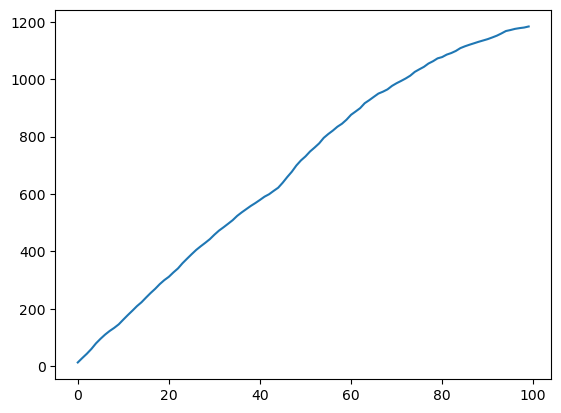

In [35]:
sns.lineplot(xG_dict_cumm)

In [36]:
xG_norm = float(0)
xG_dict = {}

for i in range(100):
    xG_norm = np.sum(df_min_xg[df_min_xg["time"] == i]["xG"])
    xG_dict[i] = xG_norm


<Axes: >

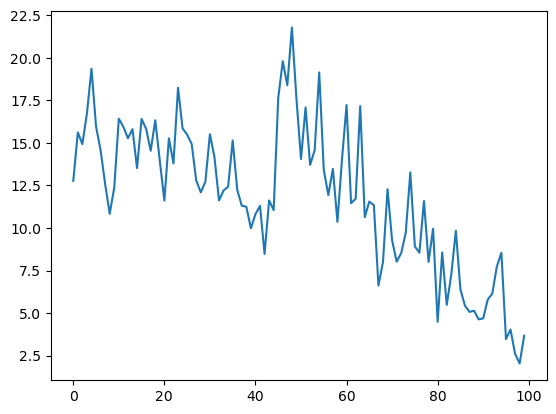

In [37]:
sns.lineplot(xG_dict)

In [38]:
df_player_xg_pos = pd.merge(df_min_xg, df_players, left_on = "player_id", right_on = "id", how = "inner")[["time_x", "player_x", "player_id", "match_id", "xG_x", "id_x", "position"]]

df_player_xg_pos['main_pos'] = df_player_xg_pos['position'].apply(lambda x: x[0])

In [39]:
df_xgtime_player = df_xgtime[df_xgtime["player"] == "Gabriel"]
df_player_min_xg = pd.merge(df_xgtime_player, df_shots, on=['player_id', 'match_id'], how='inner')
df_player_min_xg["time"] = df_player_min_xg["minute"] - df_player_min_xg["entered"]

In [40]:
xG_cummulative_player = float(0)
xG_dict_cumm_player = {}
for i in range(100):
    xG_cummulative_player = xG_cummulative_player + sum(df_player_min_xg[df_player_min_xg["time"] == i]["xG"])
    xG_dict_cumm_player[i] = xG_cummulative_player

In [41]:
xG_player = float(0)
xG_dict_player = {}
for i in range(100):
    xG_player = sum(df_player_min_xg[df_player_min_xg["time"] == i]["xG"])
    xG_dict_player[i] = xG_player

Her bir mevki için toplam oyuncu sayısını oranlamak için aşağıdaki ölçüler kullanılır.

In [42]:
df_player_xg_pos.groupby("main_pos").size()

main_pos
D    2323
F    4714
G       9
M    2636
S      71
dtype: int64

In [43]:
2270 + 4605 + 2568

9443

In [44]:
avg_player_per_match = (np.mean(df_player_xg_pos[df_player_xg_pos["main_pos"] != "G"].groupby("match_id")["player_id"].agg("size")))/2

<Axes: >

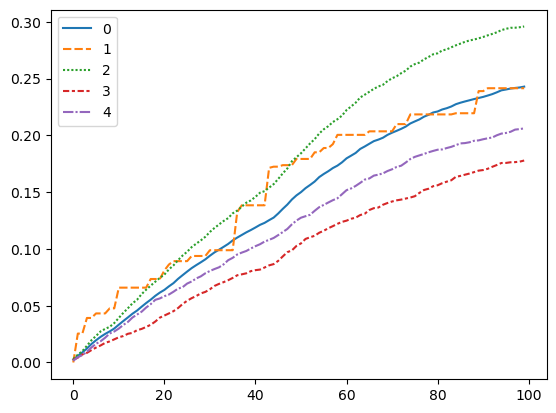

In [45]:
df_min_xg_fw = df_player_xg_pos[df_player_xg_pos["main_pos"] == "F"]
df_min_xg_def =  df_player_xg_pos[df_player_xg_pos["main_pos"] == "M"]
df_min_xg_mid =  df_player_xg_pos[df_player_xg_pos["main_pos"] == "D"]

general_xg_scaled = [x / (df_min_xg["match_id"].nunique() 
                          * avg_player_per_match
                         ) for x in list(xG_dict_cumm.values())]


xG_cummulative_fw = 0
xG_dict_cumm_fw = {}
for i in range(100):
    xG_cummulative_fw = xG_cummulative_fw + sum(df_min_xg_fw[df_min_xg_fw["time_x"] == i]["xG_x"])
    xG_dict_cumm_fw[i] = xG_cummulative_fw
fw_xg_scaled = [(x / (df_min_xg_fw["match_id"].nunique()
                       * avg_player_per_match * (4605/9443)
                     ))  for x in list(xG_dict_cumm_fw.values())]

xG_cummulative_def = 0
xG_dict_cumm_def = {}
for i in range(100):
    xG_cummulative_def = xG_cummulative_def + sum(df_min_xg_def[df_min_xg_def["time_x"] == i]["xG_x"])
    xG_dict_cumm_def[i] = xG_cummulative_def
def_xg_scaled = [(x / (df_min_xg_def["match_id"].nunique() 
                        * avg_player_per_match * (2270/9443) 
                      )) for x in list(xG_dict_cumm_def.values())]

xG_cummulative_mid = 0
xG_dict_cumm_mid = {}
for i in range(100):
    xG_cummulative_mid = xG_cummulative_mid + sum(df_min_xg_mid[df_min_xg_mid["time_x"] == i]["xG_x"])
    xG_dict_cumm_mid[i] = xG_cummulative_mid
mid_xg_scaled = [(x / (df_min_xg_mid["match_id"].nunique()
                        * avg_player_per_match * (2568/9443)
                      )) for x in list(xG_dict_cumm_mid.values())]
    

player_xg_scaled =  [x / df_player_min_xg["match_id"].nunique() for x in list(xG_dict_cumm_player.values())]

sns.lineplot([general_xg_scaled, player_xg_scaled, fw_xg_scaled, mid_xg_scaled, def_xg_scaled])

# newline

Anlık olarak oynayan oyuncuları filtrele

Bu oyunculara ve rakip metriklerine göre kalan zaman xG tahmini

Yedekteki oyuncu xG tahmini

TEST MAÇI: https://understat.com/match/22185 Bournemouth 2 - 1 Everton

(Bournemouth objektifinden)

Genel:
- İç / Dış saha
- Rakip xpts
- Rakip galibiyet %
- Rakip beraberlik %
- Rakip mağlubiyet %
- Rakip ortalama deep_allowed
- Rakip ortalama ppda
- Takım ortalama deep
- Takım ortalama oppda

Anlık:
- Takım kalan kısım xGBuildup (h/a, xpts, w/d/l, deepler, ppda'lar...)
- Takım kalan kısım xGChain (h/a, xpts, w/d/l, deepler, ppda'lar...)
- Takım kalan kısım xG
- Takım kalan kısım xGA
- Takım kalan kısım xA
- ilk 11 / sonradan girme
- mevcut skor farkı
- Rakip maçın geri kalan kısmında maç başına ortalama yenen gol
- Takım maçın geri kalan kısmında maç başına ortalama atılan gol
- Oyuncu(lar)'ın maçın kalan kısmındaki xG, xGBuildup, xGChain, xA beklentileri

In [83]:
df_general = {}
team_name = "Bournemouth"
team_id = 73
opp_id = 72
match_id = 22185
match = df_games[df_games["id"] == match_id]
total_opp_matches = int(df_game_hist[df_game_hist["team_id"] == opp_id].groupby("team_title").size())
total_matches = int(df_game_hist[df_game_hist["team_id"] == team_id].groupby("team_title").size())

In [84]:
if int(match["h.id"]) == team_id:
    df_general["h/a"] = 1
else:
    df_general["h/a"] = 0

In [85]:
df_general["opp_xpts"] = df_game_hist[df_game_hist["team_id"] == opp_id]["xpts"].mean()
df_general["opp_W_rate"] = sum((df_game_hist["result"] == "w") & (df_game_hist["team_id"] == opp_id)) / total_opp_matches
df_general["opp_D_rate"] = sum((df_game_hist["result"] == "d") & (df_game_hist["team_id"] == opp_id)) / total_opp_matches
df_general["opp_L_rate"] = sum((df_game_hist["result"] == "l") & (df_game_hist["team_id"] == opp_id)) / total_opp_matches
df_general["opp_deep_allowed"] = sum(df_game_hist[df_game_hist["team_id"] == opp_id]["deep_allowed"]) / total_opp_matches
df_general["opp_ppda"] = sum(df_game_hist[df_game_hist["team_id"] == opp_id]["ppda"]) / total_opp_matches

df_general["deep"] = sum(df_game_hist[df_game_hist["team_id"] == team_id]["deep"]) / total_matches
df_general["oppda"] = sum(df_game_hist[df_game_hist["team_id"] == team_id]["oppda"]) / total_matches
df_general["xpts"] = df_game_hist[df_game_hist["team_id"] == team_id]["xpts"].mean()

# df_games_total

In [86]:
df_games_total = pd.merge(df_games, df_game_hist, left_on = ["datetime", "h.id"], right_on = ["date", "team_id"], how = "inner")

In [87]:
cols = list(df_games.columns)
cols.pop(0)

'id'

In [88]:
df_games_total_team = df_games_total[
(df_games_total["h.id"] == team_id) |
(df_games_total["a.id"] == team_id)
]

In [89]:
df_games_total_team["home"] = (df_games_total_team["h.id"] == team_id).astype(int)

C:\Users\G\AppData\Local\Temp\ipykernel_14040\2279903436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games_total_team["home"] = (df_games_total_team["h.id"] == team_id).astype(int)


In [90]:
df_games_total_team.head()

,id,isResult,datetime,h.id,h.title,h.short_title,a.id,a.title,a.short_title,goals.h,...,npxGD,team_id,team_title,ppda_att,ppda_def,ppda_allowed_att,ppda_allowed_def,oppda,ppda,home
2,22277,1,2023-08-12 14:00:00,73,Bournemouth,BOU,81,West Ham,WHU,1,...,0.026850,73,Bournemouth,138,27,292,30,9.733333,5.111111,1
13,22288,1,2023-08-19 14:00:00,87,Liverpool,LIV,73,Bournemouth,BOU,3,...,0.947360,87,Liverpool,167,23,356,32,11.125000,7.260870,0
20,22296,1,2023-08-26 11:30:00,73,Bournemouth,BOU,82,Tottenham,TOT,0,...,-1.777568,73,Bournemouth,316,31,200,26,7.692308,10.193548,1
32,21928,1,2023-09-02 14:00:00,244,Brentford,BRE,73,Bournemouth,BOU,2,...,0.961720,244,Brentford,137,24,294,21,14.000000,5.708333,0
46,21942,1,2023-09-17 13:00:00,73,Bournemouth,BOU,80,Chelsea,CHE,0,...,-0.071620,73,Bournemouth,343,21,160,28,5.714286,16.333333,1


In [54]:
opp_match_ids = []
opponents = []
h_a = []
for i in df_games_total_team["id"]:

    opp_match_ids.append(i)
    
    if int(df_games_total_team[df_games_total_team["id"]== i]["h.id"]) == team_id:
        opponents.append(int(df_games_total_team[df_games_total_team["id"]== i]["a.id"]))
        h_a.append(1)
    else:
        opponents.append(int(df_games_total_team[df_games_total_team["id"]== i]["h.id"]))
        h_a.append(0)

In [55]:
df_games_total_team.drop(columns = cols, inplace = True)

C:\Users\G\AppData\Local\Temp\ipykernel_14040\647344748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games_total_team.drop(columns = cols, inplace = True)


In [58]:
df_general_train = pd.DataFrame()

opp_xpts = []
opp_W_rate = []
opp_D_rate = []
opp_L_rate = []
opp_deep_allowed = []
opp_ppda = []


for op_id in opponents:
    
    total_opp_matches = df_game_hist[df_game_hist["team_id"] == op_id].groupby("team_title").size()
    opp_xpts.append(df_game_hist[df_game_hist["team_id"] == op_id]["xpts"].mean())
    opp_W_rate.append(sum((df_game_hist["result"] == "w") & (df_game_hist["team_id"] == op_id)) / int(total_opp_matches))
    opp_D_rate.append(sum((df_game_hist["result"] == "d") & (df_game_hist["team_id"] == op_id)) / int(total_opp_matches))
    opp_L_rate.append(sum((df_game_hist["result"] == "l") & (df_game_hist["team_id"] == op_id)) / int(total_opp_matches))
    opp_deep_allowed.append(sum((df_game_hist[df_game_hist["team_id"] == op_id]["deep_allowed"]) / int(total_opp_matches)))
    opp_ppda.append(sum(df_game_hist[df_game_hist["team_id"] == op_id]["ppda"]) / int(total_opp_matches))

In [59]:
df_general_train["deep"] = df_games_total_team["deep"]
df_general_train["oppda"] = df_games_total_team["oppda"]
df_general_train["opp_xpts"] = opp_xpts
df_general_train["opp_W_rate"] = opp_W_rate
df_general_train["opp_D_rate"] = opp_D_rate
df_general_train["opp_L_rate"] = opp_L_rate
df_general_train["opp_deep_allowed"] = opp_deep_allowed
df_general_train["opp_ppda"] = opp_ppda
df_general_train["match_id"] = opp_match_ids
df_general_train["opp_id"] = opponents
df_general_train["isHome"] = h_a
df_general_train["xG_player"] = xG_player

In [60]:
df_general_train.shape

(36, 12)

In [91]:
df_general_train

,deep,oppda,opp_xpts,opp_W_rate,opp_D_rate,opp_L_rate,opp_deep_allowed,opp_ppda,match_id,opp_id,isHome,xG_player
2,9,9.733333,1.089234,0.371429,0.285714,0.342857,11.800000,17.583765,22277,81,1,1.208234
13,11,11.125000,2.013186,0.628571,0.257143,0.114286,5.971429,7.987515,22288,87,0,0.153227
20,6,7.692308,1.498929,0.529412,0.176471,0.294118,6.823529,7.785350,22296,82,1,0.076473
32,15,14.000000,1.404550,0.250000,0.250000,0.500000,9.111111,11.245963,21928,244,0,0.489808
46,9,5.714286,1.687691,0.411765,0.264706,0.323529,7.617647,10.577456,21942,80,1,0.292574
55,8,10.057143,1.387238,0.323529,0.323529,0.352941,8.323529,10.494165,21951,220,0,0.924114
63,13,5.964286,2.130108,0.722222,0.138889,0.138889,4.000000,9.815403,21959,83,1,0.214902
72,8,8.681818,1.403519,0.333333,0.250000,0.416667,8.166667,14.426109,21969,72,0,0.131342
81,5,6.476190,1.092106,0.361111,0.194444,0.444444,10.138889,13.680935,21975,229,1,0.895417
92,8,11.333333,0.901656,0.138889,0.250000,0.611111,10.166667,14.382073,21985,92,1,0.190028


# Player Selection

In [61]:
#player_name = input("Player name: ")
player_name = "Dominic Solanke"

In [62]:
df_appear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10558 entries, 603619 to 659062
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          10558 non-null  int64  
 1   goals          10558 non-null  int32  
 2   own_goals      10558 non-null  int32  
 3   shots          10558 non-null  int32  
 4   xG             10558 non-null  float64
 5   time           10558 non-null  int32  
 6   player_id      10558 non-null  int32  
 7   team_id        10558 non-null  int32  
 8   position       10558 non-null  object 
 9   player         10558 non-null  object 
 10  h_a            10558 non-null  object 
 11  yellow_card    10558 non-null  int32  
 12  red_card       10558 non-null  int32  
 13  roster_in      10558 non-null  int32  
 14  roster_out     10558 non-null  int32  
 15  key_passes     10558 non-null  int32  
 16  assists        10558 non-null  int32  
 17  xA             10558 non-null  float64
 18  

In [63]:
xG_player = []
for i in df_general_train["match_id"]:
    a = df_appear[(df_appear['player'] == player_name) & (df_appear['match_id'] == i)]["xG"]
    xG_player.append(float(a))
df_general_train["xG_player"] = xG_player

In [64]:
corr_general_train = df_general_train[['xG_player',
                                       'deep',
                                       'oppda',
                                       'opp_xpts',
                                       'opp_W_rate',
                                       'opp_D_rate',
                                       'opp_deep_allowed',
                                       'opp_ppda',
                                       'isHome']]


Text(0.5, 1.0, 'df_general_train Korelasyon Matrisi')

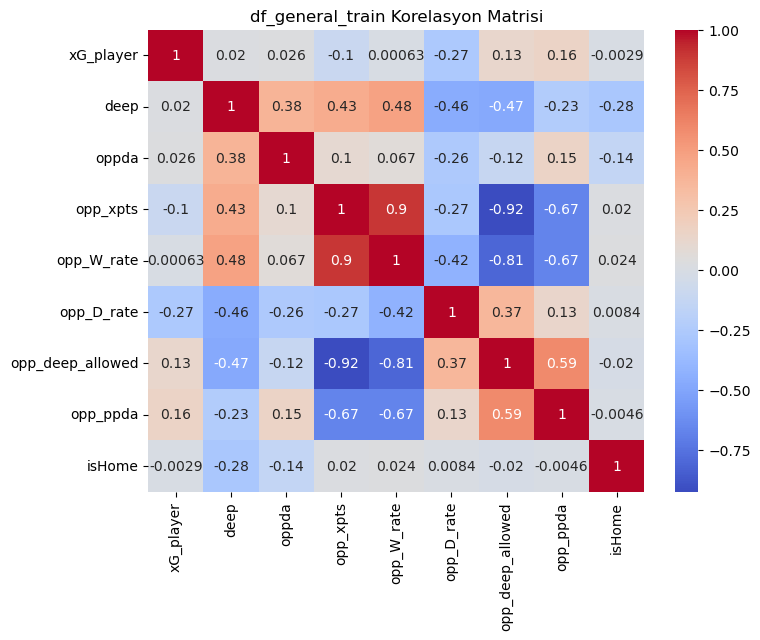

In [65]:
corr_general_train = corr_general_train.corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_general_train, annot=True, cmap='coolwarm', cbar=True)
plt.title("df_general_train Korelasyon Matrisi")

## REGRESYON İLE XG TAHMİNİ ##

ANN, LR, RTREE, RFR, SVR, ANN-R

In [66]:
df_general_train.head()

,deep,oppda,opp_xpts,opp_W_rate,opp_D_rate,opp_L_rate,opp_deep_allowed,opp_ppda,match_id,opp_id,isHome,xG_player
2,9,9.733333,1.089234,0.371429,0.285714,0.342857,11.800000,17.583765,22277,81,1,1.208234
13,11,11.125000,2.013186,0.628571,0.257143,0.114286,5.971429,7.987515,22288,87,0,0.153227
20,6,7.692308,1.498929,0.529412,0.176471,0.294118,6.823529,7.785350,22296,82,1,0.076473
32,15,14.000000,1.404550,0.250000,0.250000,0.500000,9.111111,11.245963,21928,244,0,0.489808
46,9,5.714286,1.687691,0.411765,0.264706,0.323529,7.617647,10.577456,21942,80,1,0.292574


In [67]:
df_general_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 2 to 348
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   deep              36 non-null     int32  
 1   oppda             36 non-null     float64
 2   opp_xpts          36 non-null     float64
 3   opp_W_rate        36 non-null     float64
 4   opp_D_rate        36 non-null     float64
 5   opp_L_rate        36 non-null     float64
 6   opp_deep_allowed  36 non-null     float64
 7   opp_ppda          36 non-null     float64
 8   match_id          36 non-null     int64  
 9   opp_id            36 non-null     int64  
 10  isHome            36 non-null     int64  
 11  xG_player         36 non-null     float64
dtypes: float64(8), int32(1), int64(3)
memory usage: 3.5 KB


In [68]:
df_general_train

,deep,oppda,opp_xpts,opp_W_rate,opp_D_rate,opp_L_rate,opp_deep_allowed,opp_ppda,match_id,opp_id,isHome,xG_player
2,9,9.733333,1.089234,0.371429,0.285714,0.342857,11.800000,17.583765,22277,81,1,1.208234
13,11,11.125000,2.013186,0.628571,0.257143,0.114286,5.971429,7.987515,22288,87,0,0.153227
20,6,7.692308,1.498929,0.529412,0.176471,0.294118,6.823529,7.785350,22296,82,1,0.076473
32,15,14.000000,1.404550,0.250000,0.250000,0.500000,9.111111,11.245963,21928,244,0,0.489808
46,9,5.714286,1.687691,0.411765,0.264706,0.323529,7.617647,10.577456,21942,80,1,0.292574
55,8,10.057143,1.387238,0.323529,0.323529,0.352941,8.323529,10.494165,21951,220,0,0.924114
63,13,5.964286,2.130108,0.722222,0.138889,0.138889,4.000000,9.815403,21959,83,1,0.214902
72,8,8.681818,1.403519,0.333333,0.250000,0.416667,8.166667,14.426109,21969,72,0,0.131342
81,5,6.476190,1.092106,0.361111,0.194444,0.444444,10.138889,13.680935,21975,229,1,0.895417
92,8,11.333333,0.901656,0.138889,0.250000,0.611111,10.166667,14.382073,21985,92,1,0.190028


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

X = df_general_train.drop(['xG_player',
#                           'deep',
                           'oppda',
#                           'opp_xpts',
                           'opp_W_rate',
#                           'opp_D_rate',
                           'opp_L_rate',
#                           'opp_deep_allowed',
#                           'opp_ppda',
                           'isHome',
                           'match_id',
                           'opp_id'
                          ], axis=1)
y = df_general_train['xG_player']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Regression Tree': DecisionTreeRegressor(),
    'SVR': SVR(),
    'ANN': MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000)
}

results = {}

print("Test Data\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, predictions)
    
    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r_squared
    }

for model_name, metrics in results.items():
    print(f"{model_name} Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print()


#################
print('Train Data\n')
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    mae = mean_absolute_error(y_train, predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_train, predictions)
    
    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r_squared
    }

for model_name, metrics in results.items():
    print(f"{model_name} Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print()


Test Data

Linear Regression Metrics:
MSE: 0.3393578197104666
MAE: 0.44860054745041344
RMSE: 0.5825442641640776
R-squared: -0.23937306712582873

Regression Tree Metrics:
MSE: 0.27765279357938144
MAE: 0.4702074099332094
RMSE: 0.5269276929327035
R-squared: -0.014019345916723047

SVR Metrics:
MSE: 0.2547669745660331
MAE: 0.37424799399027364
RMSE: 0.5047444646214886
R-squared: 0.06956224866229621

ANN Metrics:
MSE: 0.4142836189776592
MAE: 0.5671810980149585
RMSE: 0.6436486766689257
R-squared: -0.5130105442992201

Train Data

Linear Regression Metrics:
MSE: 0.14417175325952478
MAE: 0.32196013493735187
RMSE: 0.37969955657009236
R-squared: 0.26514165224377195

Regression Tree Metrics:
MSE: 0.0
MAE: 0.0
RMSE: 0.0
R-squared: 1.0

SVR Metrics:
MSE: 0.19431772447625772
MAE: 0.32457282199524473
RMSE: 0.4408148414881896
R-squared: 0.00954244697763762

ANN Metrics:
MSE: 0.06430131927235527
MAE: 0.17788646888803683
RMSE: 0.25357704799992303
R-squared: 0.6722495206535407



# NEWLINE

Anlık:
- Takım kalan kısım xGBuildup (h/a, xpts, w/d/l, deepler, ppda'lar...)
- Takım kalan kısım xGChain (h/a, xpts, w/d/l, deepler, ppda'lar...)
- Takım kalan kısım xG
- Takım kalan kısım xGA
- Takım kalan kısım xA
- ilk 11 / sonradan girme
- mevcut skor farkı
- Rakip maçın geri kalan kısmında maç başına ortalama yenen gol
- Takım maçın geri kalan kısmında maç başına ortalama atılan gol
- Oyuncu(lar)'ın maçın kalan kısmındaki xG, xGBuildup, xGChain, xA beklentileri

In [107]:
#df_appear[df_appear['player_id'] == 1679].head()
#df_appear[df_appear['match_id'] == 22277].head()
df_shots[df_shots['match_id'] == 22277].head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,shotType,match_id,h_team,a_team,date,player_assisted,lastAction
44,532014,2,MissedShots,0.839,0.633,0.049186,Pablo Fornals,a,2335,OpenPlay,RightFoot,22277,Bournemouth,West Ham,2023-08-12 14:00:00,NaN,NaN
45,532015,4,MissedShots,0.738,0.637,0.027623,Jarrod Bowen,a,1776,OpenPlay,LeftFoot,22277,Bournemouth,West Ham,2023-08-12 14:00:00,NaN,BallRecovery
46,532017,16,BlockedShot,0.865,0.419,0.158182,Jarrod Bowen,a,1776,OpenPlay,LeftFoot,22277,Bournemouth,West Ham,2023-08-12 14:00:00,Said Benrahma,TakeOn
47,532018,18,MissedShots,0.972,0.491,0.583935,Tomas Soucek,a,8288,FromCorner,Head,22277,Bournemouth,West Ham,2023-08-12 14:00:00,Jarrod Bowen,Aerial
48,532019,23,MissedShots,0.956,0.380,0.013436,Tomas Soucek,a,8288,FromCorner,Head,22277,Bournemouth,West Ham,2023-08-12 14:00:00,Jarrod Bowen,Aerial


In [111]:
# df_current_status = pd.DataFrame()

# isHome = []
# min = []
# mins_played = []
# goals_scored = []
# goals_con = ceded = []
# total_xg = []
# opp_total_xg = []
# exp_goals = []
# opp_exp_goals = []
# exp_goals_concede = []
# exp_total_xg = []
# exp_opp_total_xg = []

# player_id = 
# match_id = 22277
# team_title = "Bournemouth"
# minute = 75
# ha = h

# df_temp = df_shots[(df_shots['match_id'] == match_id) & (df_shots['minute'] < minute) ]


# if df_temp["h_team"] == team_title:
#     isHome.append(1)
# else:
#     isHome.append(0)

# min.append(minute)
# mins_played.append(int(df_appear[(df_appear['match_id'] == match_id) & (df_appear['player_id'] == player_id)]['time']) - 
#                   int(df_appear[(df_appear['match_id'] == match_id) & (df_appear['player_id'] == player_id)]['entered']))

# goals_scored.append(sum(df_temp[(df_temp['result'] == 'Goal') & (df_temp['h/a'] == ha)]))
# goals_conceded.append(sum(df_temp[(df_temp['result'] == 'Goal') & (df_temp['h/a'] != ha)]))

# df_current_status["dif"] = df_current_status["goals_scored"] - df_current_status["goals_conceded"]

# total_xg.append(sum(df_temp[df_temp['h/a'] == ha]['xG'])
# opp_total_xg.append(sum(df_temp[df_temp['h/a'] == ha]['xG'])

# df_current_status["isHome"] = isHome
# df_current_status["min"] = min
# df_current_status["mins_played"] = mins_played
# df_current_status["goals_scored"] = goals_scored
# df_current_status["goals_conceded"] = goals_conceded
# df_current_status["dif"] = dif
# df_current_status["total_xg"] = total_xg
# df_current_status["opp_total_xg"] = opp_total_xg

# df_current_status["exp_goals"] = exp_goals
# df_current_status["opp_exp_goals"] = opp_exp_goals
# df_current_status["exp_goals_concede"] = exp_goals_concede
# df_current_status["exp_total_xg"] = exp_total_xg
# df_current_status["exp_opp_total_xg"] = exp_opp_total_xg


In [136]:
df_appear_new = df_appear[['goals', 'shots', 'xG', 'time', 'player_id', 'team_id', 'position', 'player', 'h_a', 'yellow_card', 'xA', 'xGChain', 'xGBuildup', 'positionOrder', 'match_id', 'entered']]
df_shots_new = df_shots[['id', 'minute', 'result', 'xG', 'player', 'match_id', 'player_id', 'h_team', 'a_team']]
df_appear_shots = pd.merge(df_appear_new, df_shots_new, on = ['match_id', 'player_id'], how = 'inner')

In [137]:
df_appear_shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9521 entries, 0 to 9520
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   goals          9521 non-null   int32  
 1   shots          9521 non-null   int32  
 2   xG_x           9521 non-null   float64
 3   time           9521 non-null   int32  
 4   player_id      9521 non-null   int32  
 5   team_id        9521 non-null   int32  
 6   position       9521 non-null   object 
 7   player_x       9521 non-null   object 
 8   h_a            9521 non-null   object 
 9   yellow_card    9521 non-null   int32  
 10  xA             9521 non-null   float64
 11  xGChain        9521 non-null   float64
 12  xGBuildup      9521 non-null   float64
 13  positionOrder  9521 non-null   int32  
 14  match_id       9521 non-null   int32  
 15  entered        9521 non-null   int64  
 16  id             9521 non-null   int32  
 17  minute         9521 non-null   int32  
 18  result  

In [138]:
m_id = 22275
df_appear_shots[df_appear_shots['id'] == 531940]['minute']

2    54
Name: minute, dtype: int32

In [152]:
minute = 20
team_id = 73

df_anlik = df_appear_shots[(df_appear_shots['minute'] <= minute) & (df_appear_shots['team_id'] == team_id)]

df_anlik2 = df_appear_shots[(df_appear_shots['team_id'] == team_id)]

df_anlik2[['match_id']]

# df_anlik.groupby('match_id')['xG_y'].agg('sum')

# mins_played = []
# fst_11 = []
# dif = []
# avg_team_xGBuildup = []
# avg_team_xGChain = []
# avg_team_xA = []
# player_exp_xg = []
# player_actual_xg = []

,match_id
60,22277
61,22277
62,22277
63,22277
64,22277
...,...
9467,22235
9468,22235
9469,22235
9470,22235


In [141]:
df_anlik.info()

<class 'pandas.core.frame.DataFrame'>
Index: 389 entries, 60 to 9470
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   goals          389 non-null    int32  
 1   shots          389 non-null    int32  
 2   xG_x           389 non-null    float64
 3   time           389 non-null    int32  
 4   player_id      389 non-null    int32  
 5   team_id        389 non-null    int32  
 6   position       389 non-null    object 
 7   player_x       389 non-null    object 
 8   h_a            389 non-null    object 
 9   yellow_card    389 non-null    int32  
 10  xA             389 non-null    float64
 11  xGChain        389 non-null    float64
 12  xGBuildup      389 non-null    float64
 13  positionOrder  389 non-null    int32  
 14  match_id       389 non-null    int32  
 15  entered        389 non-null    int64  
 16  id             389 non-null    int32  
 17  minute         389 non-null    int32  
 18  result       

In [142]:
df_appear_shots[(df_appear_shots['minute'] < 80) & (df_appear_shots['match_id'] == m_id)].head()

,goals,shots,xG_x,time,player_id,team_id,position,player_x,h_a,yellow_card,...,positionOrder,match_id,entered,id,minute,result,xG_y,player_y,h_team,a_team
0,0,1,0.109350,84,579,88,DC,Nathan Aké,a,0,...,3,22275,0,531944,74,BlockedShot,0.109350,Nathan Aké,Burnley,Manchester City
1,0,1,0.018894,22,447,88,DMC,Kevin De Bruyne,a,0,...,7,22275,0,531930,5,MissedShots,0.018894,Kevin De Bruyne,Burnley,Manchester City
2,1,4,0.794211,90,2496,88,DMC,Rodri,a,0,...,7,22275,0,531940,54,SavedShot,0.014353,Rodri,Burnley,Manchester City
3,1,4,0.794211,90,2496,88,DMC,Rodri,a,0,...,7,22275,0,531941,54,SavedShot,0.020432,Rodri,Burnley,Manchester City
4,1,4,0.794211,90,2496,88,DMC,Rodri,a,0,...,7,22275,0,531943,66,BlockedShot,0.100109,Rodri,Burnley,Manchester City


In [80]:
df_status = pd.DataFrame()
df_status['mins_played'] = 
df_status['fst_11'] = 
df_status['dif'] = 
df_status['avg_team_xGBuildup'] = 
df_status['avg_team_xGChain'] = 
df_status['avg_team_xA'] = 
df_status['player_exp_xg'] = 
df_status['player_actual_xg'] = 

SyntaxError: invalid syntax (3618485048.py, line 2)

# df_status

In [274]:
team = 'Bournemouth'
team_id = 73
player = 'Dominic Solanke'
match_id = 22185
minute = 70
minute_left = 20

In [275]:
df_status = pd.DataFrame()

col_min = []
col_match_id = []
col_dif = []

for i in df_shots['match_id'].drop_duplicates():
    for j in range(106):
        col_min.append(j)
        col_match_id.append(i)
        
df_status['match_id'] = col_match_id
df_status['minute'] = col_min

df_status2 = pd.merge(df_status, df_shots, on = ['match_id', 'minute'], how = 'left')
df_status2.fillna(0, inplace = True)

col_dif = []
for i in df_status2['match_id'].drop_duplicates():
    temp_goal_h = 0
    temp_goal_a = 0
    for j in range(106):
        
        temp_filter = df_status2[(df_status2['match_id'] == i) & (df_status2['minute'] == j) & (df_status2['result'] == 'Goal')]
        
        temp_test = temp_filter['h_a']
        if  list(temp_test) == ['h']:
            temp_goal_h += 1
        elif list(temp_test) == ['a']:
            temp_goal_a += 1
        col_dif.append(temp_goal_h - temp_goal_a)
        
df_status['dif'] = col_dif

In [314]:
df_status[df_status['match_id'] == 22185].head(90)

,match_id,minute,dif
30104,22185,0,0
30105,22185,1,0
30106,22185,2,0
30107,22185,3,0
30108,22185,4,0
...,...,...,...
30189,22185,85,1
30190,22185,86,0
30191,22185,87,0
30192,22185,88,0


In [416]:
df_status_team['xG_team_prev'] = 0
df_status_team['xG_team_prev'] = 0
df_status_team['xG_team_after'] = 0
df_status_team['xG_player_prev'] = 0
df_status_team['xG_player_after'] = 0

In [417]:
df_status

,match_id,minute,dif
0,22275,0,0
1,22275,1,0
2,22275,2,0
3,22275,3,-1
4,22275,4,-1
...,...,...,...
37413,22253,101,4
37414,22253,102,4
37415,22253,103,4
37416,22253,104,4


In [418]:
df_team_shots = team_specific_shots(team)

In [439]:
df_status_team = pd.DataFrame()
df_status_team['match_id'] = df_team_shots['match_id'].drop_duplicates()
df_status_team['xG_team_prev'] = 0
df_status_team['xG_team_prev'] = 0
df_status_team['xG_team_after'] = 0
df_status_team['xG_player_prev'] = 0
df_status_team['xG_player_after'] = 0
df_status_team['dif'] = 0

In [440]:
df_status_team.head(2)

,match_id,xG_team_prev,xG_team_after,xG_player_prev,xG_player_after,dif
60,22277,0,0,0,0,0
373,22288,0,0,0,0,0


In [441]:
# xG_team_prev, xG_team_after

In [442]:
df_shots_prev = df_team_shots[df_team_shots['minute'] <= minute]
df_shots_after = df_team_shots[df_team_shots['minute'] > minute]
df_shots_prev = df_shots_prev.groupby('match_id')['xG'].sum() / minute
df_shots_after = df_shots_after.groupby('match_id')['xG'].sum() / minute_left

In [443]:
df_status_team.set_index('match_id', inplace=True)
df_status_team.reset_index(inplace=True)

In [444]:
for i in df_status_team['match_id']:
    try:
        df_status_team.iloc[df_status_team[(df_status_team['match_id'] == i)].index, 1] = df_shots_prev[i]
        df_status_team.iloc[df_status_team[(df_status_team['match_id'] == i)].index, 2] = df_shots_after[i]
    except:
        try:
            df_status_team.iloc[df_status_team[(df_status_team['match_id'] == i)].index, 2] = df_shots_after[i]
        except:
            try:
                df_status_team.iloc[df_status_team[(df_status_team['match_id'] == i)].index, 1] = df_shots_prev[i]
            except:
                continue

In [445]:
# xG_player_prev, xG_player_after

In [446]:
df_shots_prev = df_team_shots[(df_team_shots['minute'] <= minute) & (df_team_shots['player'] == player)]
df_shots_after = df_team_shots[(df_team_shots['minute'] > minute) & (df_team_shots['player'] == player)]
df_shots_prev = df_shots_prev.groupby('match_id')['xG'].sum() / minute
df_shots_after = df_shots_after.groupby('match_id')['xG'].sum() / minute_left

In [447]:
for i in df_status_team['match_id']:
    try:
        df_status_team.iloc[df_status_team[(df_status_team['match_id'] == i)].index, 3] = df_shots_prev[i]
        df_status_team.iloc[df_status_team[(df_status_team['match_id'] == i)].index, 4] = df_shots_after[i]
    except:
        try:
            df_status_team.iloc[df_status_team[(df_status_team['match_id'] == i)].index, 4] = df_shots_after[i]
        except:
            try:
                df_status_team.iloc[df_status_team[(df_status_team['match_id'] == i)].index, 3] = df_shots_prev[i]
            except:
                continue

In [448]:
# dif

In [449]:
dif = []
for i in df_status_team['match_id']:
    dif.append(int(df_status[(df_status['match_id'] == i) & (df_status['minute'] == minute)]['dif']))
df_status_team['dif'] = dif

In [450]:
home = []
h_a = []
for i in df_team_shots[['match_id', 'h_a']].drop_duplicates()['h_a']:
    if i == 'h':
        home.append(1)
        h_a.append(1)
    else:
        home.append(-1)
        h_a.append(0)
df_status_team['h_a'] = h_a   

In [451]:
df_status_team['dif'] = np.array(dif) * np.array(home)

In [452]:
# team player ratios

In [453]:
df_status_team['xG_player_team_ratio_prev'] = df_status_team['xG_player_prev'] / df_status_team['xG_team_prev']
df_status_team['xG_player_team_ratio_after'] = df_status_team['xG_player_after'] / df_status_team['xG_team_after']

In [454]:
entered = df_appear[(df_appear['team_id'] == team_id) & (df_appear['player'] == player)][['match_id', 'entered']].head(40)

In [455]:
df_status_team['playtime'] = list(minute - entered['entered'])

In [456]:
df_status_team.fillna(0)

,match_id,xG_team_prev,xG_team_after,xG_player_prev,xG_player_after,dif,h_a,xG_player_team_ratio_prev,xG_player_team_ratio_after,playtime
0,22277,0.006333,0.053348,0.003527,0.048066,-1,1,0.556982,0.901001,70
1,22288,0.006537,0.052887,0.000335,0.006488,-2,0,0.051274,0.122680,70
2,22296,0.005258,0.005878,0.000000,0.003824,-2,1,0.000000,0.650475,70
3,21928,0.015320,0.052022,0.006997,0.000000,0,0,0.456729,0.000000,70
4,21942,0.011640,0.025518,0.000000,0.014629,0,1,0.000000,0.573268,70
5,21951,0.007398,0.055135,0.004650,0.029929,0,0,0.628597,0.542835,70
6,21959,0.006957,0.007872,0.003070,0.000000,-3,1,0.441281,0.000000,70
7,21969,0.002984,0.038642,0.000568,0.004580,-3,0,0.190277,0.118517,70
8,21975,0.014063,0.001711,0.012792,0.000000,0,1,0.909596,0.000000,70
9,21985,0.015424,0.001204,0.002715,0.000000,0,1,0.176007,0.000000,70


In [458]:
pd.merge(df_status_team, df_general_train, on = 'match_id', how = 'inner').corr()

,match_id,xG_team_prev,xG_team_after,xG_player_prev,xG_player_after,dif,h_a,xG_player_team_ratio_prev,xG_player_team_ratio_after,playtime,...,oppda,opp_xpts,opp_W_rate,opp_D_rate,opp_L_rate,opp_deep_allowed,opp_ppda,opp_id,isHome,xG_player
match_id,1.000000,0.166812,0.148800,0.007065,-0.081726,0.017734,0.175003,-0.094476,-0.080873,NaN,...,-0.057766,-0.236806,-0.186585,-0.006773,0.204762,0.161756,0.041856,0.243048,0.175003,-0.035048
xG_team_prev,0.166812,1.000000,-0.119301,0.592487,-0.318256,0.592671,0.004951,0.095339,-0.349123,NaN,...,-0.043182,-0.464501,-0.351757,-0.171175,0.431836,0.390460,0.451819,0.353271,0.004951,0.407399
xG_team_after,0.148800,-0.119301,1.000000,-0.071822,0.547419,-0.157446,0.045794,0.041571,0.096748,NaN,...,0.432228,-0.078117,-0.191744,0.143484,0.166916,0.094244,0.133527,0.145966,0.045794,0.211177
xG_player_prev,0.007065,0.592487,-0.071822,1.000000,-0.191647,0.301221,-0.078545,0.733681,-0.338757,NaN,...,-0.077560,-0.129409,-0.016592,-0.372079,0.125637,0.072973,0.224488,0.084368,-0.078545,0.864531
xG_player_after,-0.081726,-0.318256,0.547419,-0.191647,1.000000,0.068603,0.142094,0.102363,0.696902,NaN,...,0.197492,0.045537,0.032418,0.179344,-0.087101,0.114310,-0.116019,-0.070544,0.142094,0.327579
dif,0.017734,0.592671,-0.157446,0.301221,0.068603,1.000000,0.017306,-0.056969,0.098961,NaN,...,-0.151774,-0.522224,-0.517608,0.170413,0.513318,0.521723,0.324346,0.328694,0.017306,0.325106
h_a,0.175003,0.004951,0.045794,-0.078545,0.142094,0.017306,1.000000,-0.162230,0.062570,NaN,...,-0.139370,0.019729,0.024442,0.008351,-0.028982,-0.020449,-0.004562,-0.060869,1.000000,-0.002850
xG_player_team_ratio_prev,-0.094476,0.095339,0.041571,0.733681,0.102363,-0.056969,-0.162230,1.000000,-0.178589,NaN,...,0.188511,0.123689,0.212794,-0.343126,-0.132061,-0.115455,0.014713,-0.018559,-0.162230,0.758708
xG_player_team_ratio_after,-0.080873,-0.349123,0.096748,-0.338757,0.696902,0.098961,0.062570,-0.178589,1.000000,NaN,...,-0.065092,0.044765,0.075641,0.167590,-0.128244,0.048064,-0.236108,0.004476,0.062570,0.031605
playtime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
df_general_train.head()

,deep,oppda,opp_xpts,opp_W_rate,opp_D_rate,opp_L_rate,opp_deep_allowed,opp_ppda,match_id,opp_id,isHome,xG_player
2,9,9.733333,1.089234,0.371429,0.285714,0.342857,11.800000,17.583765,22277,81,1,1.208234
13,11,11.125000,2.013186,0.628571,0.257143,0.114286,5.971429,7.987515,22288,87,0,0.153227
20,6,7.692308,1.498929,0.529412,0.176471,0.294118,6.823529,7.785350,22296,82,1,0.076473
32,15,14.000000,1.404550,0.250000,0.250000,0.500000,9.111111,11.245963,21928,244,0,0.489808
46,9,5.714286,1.687691,0.411765,0.264706,0.323529,7.617647,10.577456,21942,80,1,0.292574


In [ ]:
df_status_player_match